# FOB Data Pre-Processing for Modeling

## Setup and Library Imports

In [1]:
! pip install mlxtend -q

In [3]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector

In [4]:
# Display entire dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [5]:
cd '/Users/shifraisaacs/Documents/GH/FOB_LR'

/Users/shifraisaacs/Documents/GH/FOB_LR


### Load Data

In [46]:
fob_songs = pd.read_csv('data/processed/FOB_songs_processed.csv', index_col=0)

In [47]:
# Rearrange columns with numbers on the left and categoricals on the right
# Exclude release_date column
fob_songs = fob_songs[['title', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'total_words', 'unique_words', 'duration_min',
           'key', 'mode', 'time_signature', 'class']]
fob_songs.head()

,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,total_words,unique_words,duration_min,key,mode,time_signature,class
0,Honorable Mention,0.384,0.969,-3.903,0.0985,0.00236,0.000000,0.277,0.374,103.858,201,74,3.43,5,1,4,pre-hiatus
1,Calm Before the Storm,0.338,0.919,-5.538,0.3160,0.00391,0.000251,0.307,0.464,173.643,289,141,4.73,9,1,4,pre-hiatus
2,Switchblades and Infidelity,0.374,0.990,-4.092,0.3800,0.00673,0.000003,0.250,0.336,135.163,165,45,3.24,11,1,4,pre-hiatus
3,Pretty In Punk,0.430,0.963,-4.803,0.1610,0.00347,0.000000,0.298,0.268,125.773,249,85,3.62,9,1,4,pre-hiatus
4,Growing Up,0.291,0.971,-4.066,0.3010,0.00926,0.000000,0.287,0.408,149.928,174,94,2.82,0,1,3,pre-hiatus


In [48]:
# Confirm no null values
fob_songs.isnull().sum().sum()

0

### Comparing Numeric Features
Compare means and medians frmo each numerical column across the pre and post-hiatus classes to determine which features show the most distinction

In [49]:
pre = fob_songs[fob_songs['class'] == 'pre-hiatus']
post = fob_songs[fob_songs['class'] == 'post-hiatus']
numeric= fob_songs.columns[1:-4].values
categorical = fob_songs.columns[-4:].values
pre_means, pre_medians, post_means, post_medians = [], [], [], []

In [50]:
for col in numeric:
    pre_means.append(pre[col].mean())
    post_means.append(post[col].mean())
    pre_medians.append(pre[col].median())
    post_medians.append(post[col].median())

In [51]:
# Set up dataframe to compare each mean and median with their deltas
num_features = DataFrame({'feature': numeric, 'pre-hiatus_mean': pre_means,
                         'post-hiatus_mean': post_means, 'pre-hiatus_median': pre_medians,
                         'post-hiatus_median': post_medians})
num_features['mean_delta'] = num_features['pre-hiatus_mean'] - num_features['post-hiatus_mean']
num_features['median_delta'] = num_features['pre-hiatus_median'] - num_features['post-hiatus_median']

In [52]:
num_features

,feature,pre-hiatus_mean,post-hiatus_mean,pre-hiatus_median,post-hiatus_median,mean_delta,median_delta
0,danceability,0.503910,0.501096,0.49300,0.522500,0.002814,-0.029500
1,energy,0.895124,0.884673,0.93900,0.906500,0.010451,0.032500
2,loudness,-4.129865,-4.043577,-3.84300,-3.836500,-0.086288,-0.006500
3,speechiness,0.091297,0.086667,0.07020,0.059400,0.004629,0.010800
4,acousticness,0.035990,0.021782,0.00278,0.006285,0.014208,-0.003505
5,instrumentalness,0.000052,0.044889,0.00000,0.000059,-0.044838,-0.000059
6,liveness,0.294708,0.285040,0.28400,0.237500,0.009667,0.046500
7,valence,0.541787,0.523212,0.54500,0.546500,0.018575,-0.001500
8,tempo,139.904022,136.425692,135.45000,137.030000,3.478330,-1.580000
9,total_words,289.438202,335.115385,285.00000,335.500000,-45.677182,-50.500000


### Comparing Categorical Features

Pre-Hiatus Distribution of Key


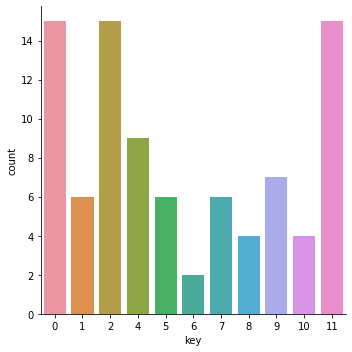

Post-Hiatus Distribution of Key


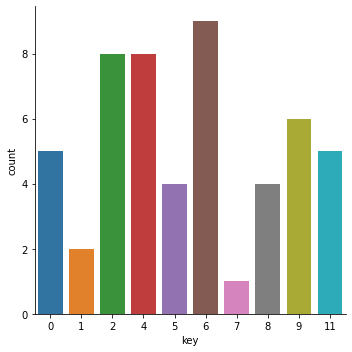


Pre-Hiatus Distribution of Mode


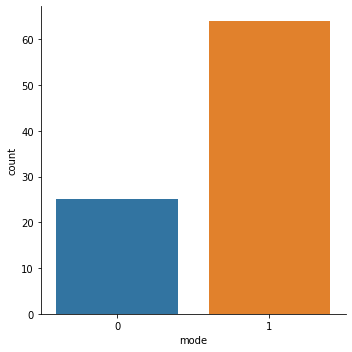

Post-Hiatus Distribution of Mode


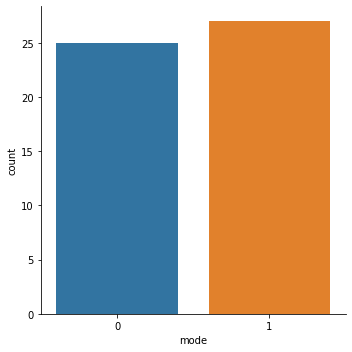


Pre-Hiatus Distribution of Time_Signature


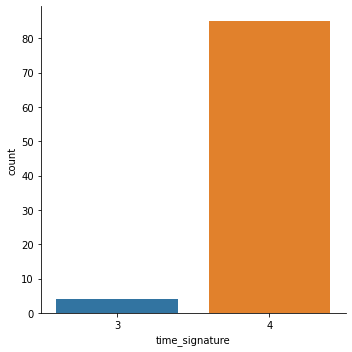

Post-Hiatus Distribution of Time_Signature


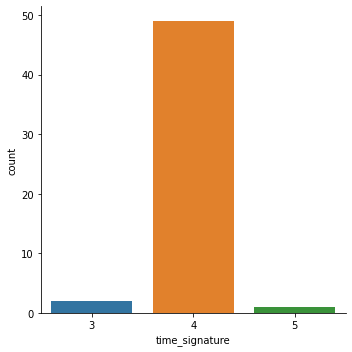

In [53]:
for col in fob_songs[categorical[:-1]]:
    print(f'Pre-Hiatus Distribution of {col.title()}')
    sns.catplot(x=col, data=pre, kind='count')
    plt.show()
    print(f'Post-Hiatus Distribution of {col.title()}')
    sns.catplot(x=col, data=post, kind='count')
    plt.show()
    print()

### Categorical Features: Conclusion
- Likely mode as a feature
- Unsure if Key should be included as a feature
- Definitely exclude Time Signature from final model, as most are 4/4

In [54]:
fob_songs.columns

Index(['title', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'total_words', 'unique_words', 'duration_min', 'key', 'mode',
       'time_signature', 'class'],
      dtype='object')

In [55]:
features = fob_songs.copy()
features.head()

,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,total_words,unique_words,duration_min,key,mode,time_signature,class
0,Honorable Mention,0.384,0.969,-3.903,0.0985,0.00236,0.000000,0.277,0.374,103.858,201,74,3.43,5,1,4,pre-hiatus
1,Calm Before the Storm,0.338,0.919,-5.538,0.3160,0.00391,0.000251,0.307,0.464,173.643,289,141,4.73,9,1,4,pre-hiatus
2,Switchblades and Infidelity,0.374,0.990,-4.092,0.3800,0.00673,0.000003,0.250,0.336,135.163,165,45,3.24,11,1,4,pre-hiatus
3,Pretty In Punk,0.430,0.963,-4.803,0.1610,0.00347,0.000000,0.298,0.268,125.773,249,85,3.62,9,1,4,pre-hiatus
4,Growing Up,0.291,0.971,-4.066,0.3010,0.00926,0.000000,0.287,0.408,149.928,174,94,2.82,0,1,3,pre-hiatus


### Feature Scaling?
With minimum values at ~1 and maximum values at ~685, scaling may not be necessary

In [56]:
features.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,total_words,unique_words,duration_min,key,mode,time_signature
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.00000,141.000000
mean,0.502872,0.891270,-4.098043,0.089589,0.030750,0.016588,0.291143,0.534936,138.621234,306.283688,113.971631,3.380567,5.163121,0.64539,3.964539
std,0.104109,0.107558,1.126646,0.063506,0.113241,0.078870,0.199129,0.163374,30.177990,104.490828,33.625871,0.651331,3.767576,0.48010,0.220757
min,0.141000,0.396000,-7.756000,0.027500,0.000045,0.000000,0.017000,0.115000,79.964000,66.000000,30.000000,1.050000,0.000000,0.00000,3.000000
25%,0.445000,0.872000,-4.604000,0.050200,0.000847,0.000000,0.122000,0.424000,114.522000,230.000000,94.000000,3.160000,2.000000,0.00000,4.000000
50%,0.500000,0.927000,-3.840000,0.064400,0.003680,0.000002,0.259000,0.545000,135.997000,304.000000,112.000000,3.400000,5.000000,1.00000,4.000000
75%,0.574000,0.956000,-3.393000,0.108000,0.009590,0.000050,0.366000,0.658000,160.040000,363.000000,132.000000,3.730000,9.000000,1.00000,4.000000
max,0.803000,0.993000,-1.697000,0.380000,0.835000,0.646000,0.922000,0.949000,207.185000,685.000000,229.000000,4.850000,11.000000,1.00000,5.000000


### Encoding
One-Hot Encode categorical variables

In [57]:
# Rough by-hand label-encoding of class column
# Pre-hiatus maps to 0; Post-hiatus maps to 1
features = features.replace('pre-hiatus', 0).replace('post-hiatus', 1)
target = features['class']
features['class'].head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [58]:
one = OneHotEncoder(sparse=False)
numbers = features[numeric].copy()
categories_df = features[categorical[:-1]].copy()
cols = categories_df.columns

In [59]:
cats_encoded = one.fit_transform(categories_df)
feature_names = one.get_feature_names_out(cols)

In [20]:
# Create df of one-hot-encoded variables
cats_df = DataFrame(cats_encoded, columns=feature_names)
# Rename mode columns for better description
cats_df.rename(columns={'mode_0' : 'mode_minor', 'mode_1' : 'mode_major'}, inplace=True)
cats_df.head()

,key_0,key_1,key_2,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_minor,mode_major,time_signature_3,time_signature_4,time_signature_5
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [60]:
# Concatenate dataframes and reorder columns
features = pd.concat([numbers, cats_df, fob_songs['class'].copy()], axis='columns')
print(features.shape)
features.head()

(141, 29)


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,total_words,unique_words,duration_min,key_0,key_1,key_2,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_minor,mode_major,time_signature_3,time_signature_4,time_signature_5,class
0,0.384,0.969,-3.903,0.0985,0.00236,0.000000,0.277,0.374,103.858,201,74,3.43,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,pre-hiatus
1,0.338,0.919,-5.538,0.3160,0.00391,0.000251,0.307,0.464,173.643,289,141,4.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,pre-hiatus
2,0.374,0.990,-4.092,0.3800,0.00673,0.000003,0.250,0.336,135.163,165,45,3.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,pre-hiatus
3,0.430,0.963,-4.803,0.1610,0.00347,0.000000,0.298,0.268,125.773,249,85,3.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,pre-hiatus
4,0.291,0.971,-4.066,0.3010,0.00926,0.000000,0.287,0.408,149.928,174,94,2.82,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,pre-hiatus


### Export all features for testing

In [61]:
features.to_csv('data/processed/all_encoded.csv')

### Data Split

In [23]:
y = features.pop('class')

### Backward Feature Selection
- Minimum of 3 features, maximum 12
- Scored with F1

In [36]:
backward = SequentialFeatureSelector(LogisticRegression(max_iter=5000),
                                     k_features=(3, 12),
                                     forward=False, floating=False,
                                     verbose=2, scoring='f1', cv=5)

In [37]:
backward.fit(features, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    7.6s finished

[2022-08-23 20:55:42] Features: 27/3 -- score: 0.4434920634920636[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    7.6s finished

[2022-08-23 20:55:49] Features: 26/3 -- score: 0.4468253968253969[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    7.4s finished

[2022-08-23 20:55:57] Features: 25/3 -- score: 0.45103592314118635[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

SequentialFeatureSelector(estimator=LogisticRegression(max_iter=5000),
                          forward=False, k_features=(3, 12), scoring='f1',
                          verbose=2)

In [69]:
final_features = list(backward.k_feature_names_)
final_features.append('class')
final_features

['instrumentalness',
 'valence',
 'total_words',
 'duration_min',
 'key_0',
 'key_6',
 'key_10',
 'key_11',
 'mode_minor',
 'mode_major',
 'class']

In [67]:
# Model score
backward.k_score_

0.4880672268907563

In [70]:
first_features = [['instrumentalness','valence', 'total_words', 'duration_min', 'key_0', 'key_6', 'key_10', 'key_11', 'mode_minor', 'mode_major', 'class']]
model_versions = {}
model_versions[0] = {'features':first_features, 'score': 0.4880672268907563}

### Export final features for modeling

In [71]:
features = features[final_features]

In [72]:
features.head()

,instrumentalness,valence,total_words,duration_min,key_0,key_6,key_10,key_11,mode_minor,mode_major,class
0,0.000000,0.374,201,3.43,0.0,0.0,0.0,0.0,0.0,1.0,pre-hiatus
1,0.000251,0.464,289,4.73,0.0,0.0,0.0,0.0,0.0,1.0,pre-hiatus
2,0.000003,0.336,165,3.24,0.0,0.0,0.0,1.0,0.0,1.0,pre-hiatus
3,0.000000,0.268,249,3.62,0.0,0.0,0.0,0.0,0.0,1.0,pre-hiatus
4,0.000000,0.408,174,2.82,1.0,0.0,0.0,0.0,0.0,1.0,pre-hiatus


In [74]:
# Rough by-hand label-encoding of class column
# Pre-hiatus maps to 0; Post-hiatus maps to 1
features = features.replace('pre-hiatus', 0).replace('post-hiatus', 1)
features['class'].head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [75]:
features.to_csv('data/processed/features_encoded.csv')